# Load YOLOV8 model

In [2]:
# Load YOLO model
from ultralytics import YOLO

MODEL_PATH = "runs/detect/train/weights/best.pt"
model = YOLO(MODEL_PATH)

print(f"✅ YOLO model loaded: {MODEL_PATH}")

# Load metrics performance .jpg and .png data files from validation files
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

METRICS_DIR = "runs/detect/val"
jpg_files = [f for f in os.listdir(METRICS_DIR) if f.endswith('.jpg')]
png_files = [f for f in os.listdir(METRICS_DIR) if f.endswith('.png')]
metrics_files = jpg_files + png_files
metrics_files.sort()  # Sort files for consistent order
print(f"✅ Found {len(metrics_files)} metrics files in {METRICS_DIR}")

✅ YOLO model loaded: runs/detect/train/weights/best.pt
✅ Found 12 metrics files in runs/detect/val


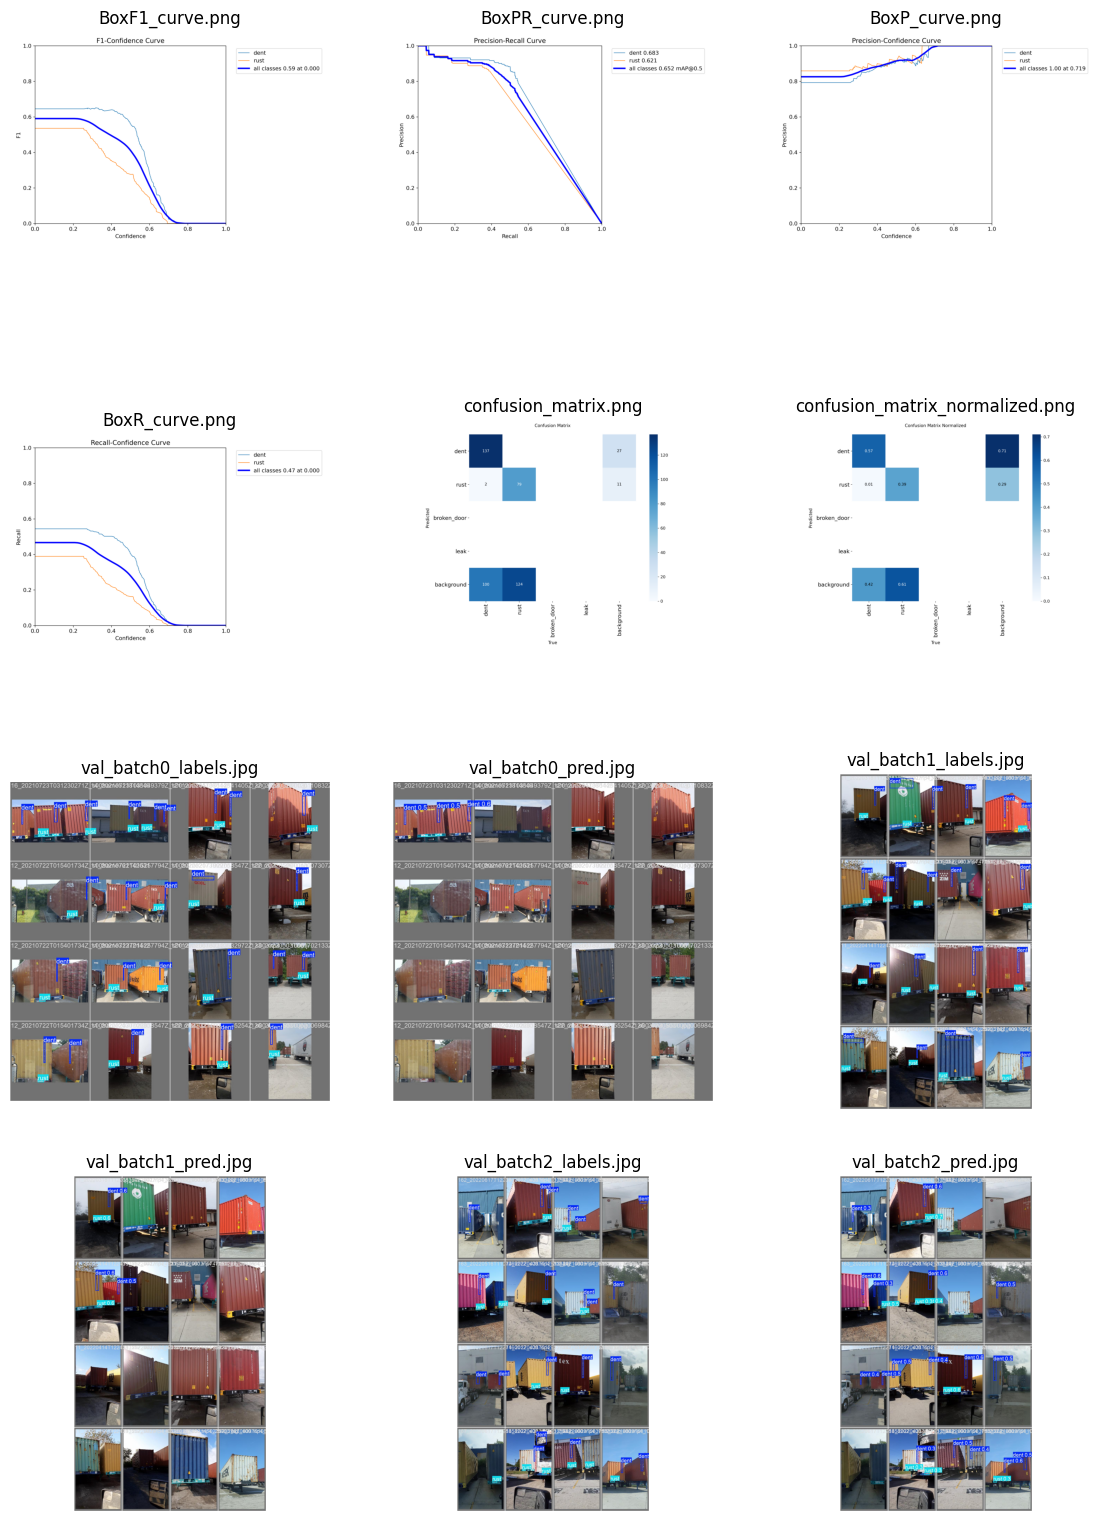

In [3]:
# Show each metrics performance file into a matplotlib window with 3 x 3 grid
num_files = len(metrics_files)
num_cols = 3
num_rows = (num_files + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 5 * num_rows))
axes = axes.flatten()  # Flatten to easily iterate over axes
for idx, file_name in enumerate(metrics_files):
    img_path = os.path.join(METRICS_DIR, file_name)
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(file_name)
    axes[idx].axis('off')

# Real time video live container damage detection
- Ingest video from youtube
- Ensure the video is reliable with YOLOV8 model are trained
- YOLOV8 Custom Model (the trained weights)
- Live detection overlay
- Risk Engine + RAG Trigger (optional)

# Extract direct video stream

In [4]:
import subprocess
import json

# Extract direct video stream
def get_stream_url(youtube_url):
    cmd = [
        "yt-dlp",
        "-f",
        "best[ext=mp4]",
        "-g",
        youtube_url
    ]
    stream_url = subprocess.check_output(cmd).decode().strip()
    return stream_url

# Download YouTube Video (Recommended)

In [5]:
import cv2

# Use local video file
VIDEO_PATH = "dataset/videos/container_video.mov"

try:
    cap = cv2.VideoCapture(VIDEO_PATH)
    
    if not cap.isOpened():
        raise Exception(f"Cannot open video file: {VIDEO_PATH}")
    
    # Get video info
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"✅ Video loaded: {VIDEO_PATH}")
    print(f"   - Resolution: {width}x{height}")
    print(f"   - FPS: {fps}")
    print(f"   - Total frames: {total_frames}")
        
except Exception as e:
    print(f"❌ Failed to open video: {e}")

✅ Video loaded: dataset/videos/container_video.mov
   - Resolution: 2940x1912
   - FPS: 47
   - Total frames: 9784


# Real-Time performance optimation

In [6]:
import numpy as np
import cv2
import time
from ultralytics import YOLO

VIDEO_PATH = "dataset/videos/container_video.mov"
CONTAINER_MODEL_PATH = "datasets_container/models/container_yolov8.pt"
DAMAGE_MODEL_PATH = "models/yolov8_container_damage.pt"

WINDOW_NAME = "LOGISTIC-RAG DRONE PIPELINE"

# =========================
# LOAD MODELS
# =========================

print("Loading container detection model...")
container_model = YOLO(CONTAINER_MODEL_PATH)
container_model.fuse()

print("Loading damage detection model...")
damage_model = YOLO(DAMAGE_MODEL_PATH)
damage_model.fuse()

print("✅ Models loaded successfully")

# =========================
# VIDEO STREAM
# =========================

cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError(f"Cannot open video file: {VIDEO_PATH}")

cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)

frame_count = 0
container_total = 0
truck_total = 0
damage_total = 0

start_time = time.time()

# =========================
# REALTIME LOOP
# =========================

while True:

    ret, frame = cap.read()

    if not ret:
        print("End of video stream")
        break

    frame_count += 1

    # -------- FRAME SKIP --------
    if frame_count % 2 != 0:
        continue

    # -------- RESIZE --------
    frame = cv2.resize(frame, None, fx=0.7, fy=0.7)

    annotated_frame = frame.copy()

    # ====================================================
    # STAGE 1 — CONTAINER + TRUCK DETECTION
    # ====================================================

    container_results = container_model.predict(
        source=frame,
        imgsz=640,
        conf=0.10,         # low threshold for drone wide shot
        iou=0.65,
        max_det=300,
        classes=[0, 1],
        device="mps",
        half=True,
        verbose=False
    )

    result = container_results[0]
    boxes = result.boxes

    frame_container_count = 0
    frame_truck_count = 0
    frame_damage_count = 0

    # ====================================================
    # STAGE 2 — DAMAGE INSPECTION
    # ====================================================

    for box in boxes:

        cls_id = int(box.cls)
        label = container_model.names[cls_id]

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)

        # --------------------------
        # CONTAINER PIPELINE
        # --------------------------

        if label == "container" and area >= 15000:

            frame_container_count += 1
            container_total += 1

            # Draw container
            cv2.rectangle(
                annotated_frame, (x1, y1), (x2, y2),
                (255, 0, 0), 2
            )

            cv2.putText(
                annotated_frame, "CONTAINER",
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                (255, 0, 0), 1
            )

            # --------------------------
            # DAMAGE ONLY FOR CLOSE + LARGE ROI
            # --------------------------

            if area >= 75000 and frame_count % 6 == 0: # Increase are interval ROI for better accuracy prevent false positive

                roi = frame[y1:y2, x1:x2]

                if roi.size == 0:
                    continue

                h, w, _ = roi.shape

                # Skip small ROI (YOLO can't detect well)
                if h < 120 or w < 120:
                    continue

                # DEBUG WINDOW (can comment after testing)
                cv2.imshow("ROI_DEBUG", roi)
                cv2.waitKey(1)

                damage_results = damage_model.predict(
                    source=roi,
                    imgsz=640,
                    conf=0.10,   # lower threshold for drone
                    device="mps",
                    half=True,
                    verbose=False
                )

                damage_boxes = damage_results[0].boxes

                print("Damage boxes:", len(damage_boxes))

                if len(damage_boxes) > 0:

                    frame_damage_count += len(damage_boxes)
                    damage_total += len(damage_boxes)

                    # Highlight container
                    cv2.rectangle(
                        annotated_frame,
                        (x1, y1), (x2, y2),
                        (0, 0, 255), 3
                    )

                    cv2.putText(
                        annotated_frame,
                        "DAMAGE",
                        (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (0, 0, 255),
                        2
                    )

                    # Draw actual damage boxes (yellow)
                    for dbox in damage_boxes:

                        dx1, dy1, dx2, dy2 = map(int, dbox.xyxy[0])

                        cv2.rectangle(
                            annotated_frame,
                            (x1 + dx1, y1 + dy1),
                            (x1 + dx2, y1 + dy2),
                            (0, 255, 255),
                            2
                        )

        # --------------------------
        # TRUCK PIPELINE
        # --------------------------

        elif label == "truck" and area >= 15000:

            frame_truck_count += 1
            truck_total += 1

            cv2.rectangle(
                annotated_frame,
                (x1, y1), (x2, y2),
                (0, 255, 0), 2
            )

            cv2.putText(
                annotated_frame, "TRUCK",
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                (0, 255, 0), 1
            )

    # ====================================================
    # UI DASHBOARD
    # ====================================================

    fps = frame_count / (time.time() - start_time + 1e-6)

    info_text = (
        f"Frame:{frame_count} | "
        f"C:{frame_container_count} | "
        f"T:{frame_truck_count} | "
        f"DAMAGE:{frame_damage_count} | "
        f"FPS:{fps:.1f}"
    )

    cv2.rectangle(annotated_frame, (0, 0), (700, 40), (0, 0, 0), -1)

    cv2.putText(
        annotated_frame,
        info_text,
        (10, 28),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2
    )

    cv2.imshow(WINDOW_NAME, annotated_frame)

    # ====================================================
    # CONTROL
    # ====================================================

    if cv2.getWindowProperty(WINDOW_NAME, cv2.WND_PROP_VISIBLE) < 1:
        break

    key = cv2.waitKey(1) & 0xFF

    if key == 27 or key == ord('q'):
        break

    elif key == 32:
        print("Paused")
        cv2.waitKey(0)

# =========================
# CLEANUP
# =========================

cap.release()
cv2.destroyAllWindows()

# =========================
# FINAL REPORT
# =========================

print("\n========= LOGISTIC-RAG REPORT =========")
print(f"Frames processed   : {frame_count}")
print(f"Containers detected: {container_total}")
print(f"Trucks detected    : {truck_total}")
print(f"Damages detected   : {damage_total}")
print("======================================")

Loading container detection model...
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
Loading damage detection model...
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
✅ Models loaded successfully
Damage boxes: 2
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Damage boxes: 0
Dama

# DAMAGE COUNTER Overlay

In [ ]:
import torch

# =========================
# DAMAGE CLASS MAP
# =========================

DAMAGE_CLASS_MAP = {
    0: "dent",
    1: "rust",
    2: "broken_door",
    3: "leak"
}

# =========================
# DAMAGE COUNTER FUNCTION
# =========================

def extract_damage_counts(result):

    counts = {
        "dent": 0,
        "rust": 0,
        "broken_door": 0,
        "leak": 0
    }

    if result.boxes is None or len(result.boxes) == 0:
        return counts

    for cls in result.boxes.cls:

        cls_id = int(cls)

        if cls_id in DAMAGE_CLASS_MAP:
            counts[DAMAGE_CLASS_MAP[cls_id]] += 1

    return counts


# =========================
# LOAD MODELS
# =========================

print("Loading container detection model...")
container_model = YOLO(CONTAINER_MODEL_PATH)
container_model.fuse()

print("Loading damage detection model...")
damage_model = YOLO(DAMAGE_MODEL_PATH)
damage_model.fuse()

print("✅ Models loaded successfully")


# =========================
# VIDEO STREAM
# =========================

cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError(f"Cannot open video file: {VIDEO_PATH}")

frame_count = 0
container_total = 0
truck_total = 0
damage_total = 0

total_damage_summary = {
    "dent": 0,
    "rust": 0,
    "broken_door": 0,
    "leak": 0
}

start_time = time.time()

print("🚀 Starting headless inference (no GUI)...")

# =========================
# REALTIME LOOP
# =========================

while True:

    ret, frame = cap.read()

    if not ret:
        print("End of video stream")
        break

    frame_count += 1

    # -------- FRAME SKIP --------
    if frame_count % 2 != 0:
        continue

    # -------- RESIZE --------
    frame = cv2.resize(frame, None, fx=0.7, fy=0.7)

    # Reset per-frame counters
    frame_damage_summary = {
        "dent": 0,
        "rust": 0,
        "broken_door": 0,
        "leak": 0
    }

    # ====================================================
    # STAGE 1 — CONTAINER + TRUCK DETECTION
    # ====================================================

    container_results = container_model.predict(
        source=frame,
        imgsz=640,
        conf=0.10,
        iou=0.65,
        max_det=300,
        classes=[0, 1],
        device="mps",
        half=True,
        verbose=True
    )

    result = container_results[0]
    boxes = result.boxes

    if boxes is None:
        continue

    frame_container_count = 0
    frame_truck_count = 0
    frame_damage_count = 0

    # ====================================================
    # STAGE 2 — DAMAGE INSPECTION
    # ====================================================

    for box in boxes:

        cls_id = int(box.cls)
        labelosa = container_model.names[int(box.cls)]

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)

        # --------------------------
        # CONTAINER
        # --------------------------

        if labelosa == "container" and area >= 15000:

            frame_container_count += 1
            container_total += 1

            # -------- DAMAGE ONLY CLOSE ROI --------

            if area >= 75000 and frame_count % 6 == 0:

                roi = frame[y1:y2, x1:x2]

                if roi.size == 0:
                    continue

                h, w, _ = roi.shape

                if h < 120 or w < 120:
                    continue

                with torch.no_grad():

                    damage_results = damage_model.predict(
                        source=roi,
                        imgsz=640,
                        conf=0.10,
                        device="mps",
                        half=True,
                        verbose=False
                    )

                damage_result = damage_results[0]
                damage_counts = extract_damage_counts(damage_result)

                if sum(damage_counts.values()) > 0:

                    frame_damage_count += sum(damage_counts.values())
                    damage_total += sum(damage_counts.values())

                    for k in frame_damage_summary:
                        frame_damage_summary[k] += damage_counts[k]
                        total_damage_summary[k] += damage_counts[k]

                del damage_results, damage_result

        # --------------------------
        # TRUCK
        # --------------------------

        elif labelosa == "truck" and area >= 15000:

            frame_truck_count += 1
            truck_total += 1

    # =========================
    # LOGGING (OPTIONAL)
    # =========================

    if frame_count % 30 == 0:

        fps = frame_count / (time.time() - start_time + 1e-6)

        print(
            f"[Frame {frame_count}] "
            f"C:{frame_container_count} "
            f"T:{frame_truck_count} "
            f"DAMAGE:{frame_damage_count} "
            f"FPS:{fps:.1f}"
        )


# =========================
# CLEANUP
# =========================

cap.release()

# =========================
# FINAL REPORT
# =========================

print("\n========= LOGISTIC-RAG REPORT =========")
print(f"Frames processed   : {frame_count}")
print(f"Containers detected: {container_total}")
print(f"Trucks detected    : {truck_total}")
print(f"Total damages      : {damage_total}")

print("\n--- DAMAGE TYPE BREAKDOWN ---")
print(f"Dents        : {total_damage_summary['dent']}")
print(f"Rust         : {total_damage_summary['rust']}")
print(f"Broken doors : {total_damage_summary['broken_door']}")
print(f"Leaks        : {total_damage_summary['leak']}")
print("=======================================")

Loading container detection model...
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
Loading damage detection model...
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
✅ Models loaded successfully
🚀 Starting headless inference (no GUI)...

0: 416x640 227 containers, 41.0ms
Speed: 8.5ms preprocess, 41.0ms inference, 16.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 224 containers, 21.8ms
Speed: 2.1ms preprocess, 21.8ms inference, 22.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 235 containers, 22.5ms
Speed: 1.7ms preprocess, 22.5ms inference, 8.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 227 containers, 26.1ms
Speed: 3.4ms preprocess, 26.1ms inference, 4.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 212 containers, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 8.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 199 containers, 6.0ms
Spee

# REAL BUSINESS MODE — Risk Trigger

In [ ]:
# =========================
# BUSINESS RISK WEIGHT
# =========================

DAMAGE_WEIGHT = {
    "dent": 1,
    "rust": 2,
    "broken_door": 3,
    "leak": 4
}

# Risk thresholds
RISK_THRESHOLDS = {
    "LOW": 1,
    "MEDIUM": 3,
    "HIGH": 6,
    "CRITICAL": 10
}

ALERT_COOLDOWN_SEC = 10   # prevent spam alert

# =========================
# SEVERITY CALCULATION
# =========================

def calculate_severity(damage_summary):

    severity_score = 0

    for k, v in damage_summary.items():
        severity_score += DAMAGE_WEIGHT[k] * v

    return severity_score


def classify_risk_level(score):

    if score >= RISK_THRESHOLDS["CRITICAL"]:
        return "CRITICAL"

    elif score >= RISK_THRESHOLDS["HIGH"]:
        return "HIGH"

    elif score >= RISK_THRESHOLDS["MEDIUM"]:
        return "MEDIUM"

    elif score >= RISK_THRESHOLDS["LOW"]:
        return "LOW"

    else:
        return "NORMAL"
    
last_alert_time = 0

# =========================
# BUSINESS RISK ENGINE
# =========================

severity_score = calculate_severity(frame_damage_summary)

risk_level = classify_risk_level(severity_score)

current_time = time.time()

if risk_level in ["HIGH", "CRITICAL"]:

    if current_time - last_alert_time > ALERT_COOLDOWN_SEC:

        print(f"⚠️ RISK ALERT | Level: {risk_level}")
        print(f"Severity Score : {severity_score}")
        print(f"Damage Detail  : {frame_damage_summary}")

        # =========================
        # PLACE INTEGRATION HERE
        # =========================
        # send_to_slack()
        # trigger_webhook()
        # save_to_database()
        # push_to_kafka()
        # call_fastapi_alert_endpoint()

        last_alert_time = current_time

# RAG Experimennt Layer

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("dataset/Pdf/Standard_container_operations.pdf") # SOP document for container getting authorized by STANDARDS FOR EMPTY SHIPPING CONTAINER INSPECTION VERSION 2 - May 2021
docs = loader.load()

print(f"✅ Loaded {len(docs)} pages from SOP document")

/Users/miftahhadiyannoor/Documents/logistics-rag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded 75 pages from SOP document


# Create Vector DB

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

print("Loading SOP Vector Database...")
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.load_local(
    "faiss_container_sop_db",
    embeddings=embedding,
    allow_dangerous_deserialization=True
)

print(f"✅ Vector database loaded successfully!")
print(f"   - Total documents: {len(docs)}")
print(f"   - Embedding model: sentence-transformers/all-MiniLM-L6-v2")
print(f"   - Database loaded from: faiss_container_sop_db/")

/var/folders/s0/01h8dy1902zgb59dr1yqy6jr0000gn/T/ipykernel_61726/3490813910.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embed = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 706.52it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Vector database created and saved!
   - Total documents: 75
   - Embedding model: sentence-transformers/all-MiniLM-L6-v2
   - Database saved to: faiss_container_sop_db/


# Prompting Using CV Result

In [ ]:
prompting = f"""
You are an AI logistics inspection assistant.

Drone Inspection Summary (Realtime):

Detected Containers   : {frame_container_count}
Detected Trucks       : {frame_truck_count}

Damage Summary:
- Dent         : {frame_damage_summary['dent']}
- Rust         : {frame_damage_summary['rust']}
- Broken Door  : {frame_damage_summary['broken_door']}
- Leak         : {frame_damage_summary['leak']}

Business Risk Assessment:
Severity Score : {severity_score}
Risk Level     : {risk_level}

Inspection Context:
- Source: High-altitude drone camera
- Location: Container yard / port terminal
- Mode: Real-time inspection

Task:
Based on the inspection result and business risk level,
recommend the operational action that should be taken
according to logistics SOP and safety regulations.
"""

# QUERY SOP CONTEXT
context_docs = db.similarity_search(
    quer=prompting,
    k=3
)

context = "\n".join([doc.page_content for doc in context_docs])

# RAG Experiment Layer
# AI Engineer concept to explainn why the container are
- 0. rust, 
- 1. dent, 
- 2. broken_door, 
- 3. leak

# AI Engineer prompt to get business problem solution

In [ ]:
from langchain_community.llms import Ollama

llm = Ollama(model="llama3")

final_prompt = f"""
SYSTEM ROLE:
You are a Senior Port Operations Engineer AI.

BUSINESS OBJECTIVE:
Analyze real-time drone inspection data and recommend operational actions
based on logistics SOP and safety regulations.

========================
SOP CONTEXT (RAG RETRIEVAL):
========================
{context}

========================
DRONE INSPECTION RESULT:
========================

Containers Detected: {frame_container_count}
Trucks Detected: {frame_truck_count}

Damage Summary:
- Dent: {frame_damage_summary['dent']}
- Rust: {frame_damage_summary['rust']}
- Broken Door: {frame_damage_summary['broken_door']}
- Leak: {frame_damage_summary['leak']}

Business Risk Assessment:
Severity Score: {severity_score}
Risk Level: {risk_level}

========================
TASK:
========================

Based on the inspection data and SOP context:

1. Identify risk category
2. Recommend immediate operational action
3. Define repair urgency (LOW / MEDIUM / HIGH / IMMEDIATE)
4. Suggest safety mitigation
5. Provide short executive summary (max 3 lines)

========================
OUTPUT FORMAT (STRICT):
========================

Risk Level:
Immediate Action:
Repair Urgency:
Safety Recommendation:
Executive Summary:
"""

print("🤖 Generating AI business recommendation...")

response = llm.invoke(final_prompt)

print("\n" + "=" * 60)
print(response)
print("=" * 60)

# Financial Estimation Layer

In [ ]:
# =========================
# REPAIR COST CONFIG (USD)
# =========================

REPAIR_COST_MAP = {
    "dent": 200,
    "rust": 300,
    "broken_door": 500,
    "leak": 750
}

# Risk multiplier (business policy)
RISK_COST_MULTIPLIER = {
    "NORMAL": 1.0,
    "LOW": 1.1,
    "MEDIUM": 1.25,
    "HIGH": 1.5,
    "CRITICAL": 2.0
}

# =========================
# Financial Calculation Function
# =========================

def calculate_repair_cost(damage_summary, risk_level):
    base_cost = 0

    for damage_type, count in damage_summary.items():
        unit_cost = REPAIR_COST_MAP.get(damage_type, 0)
        base_cost += unit_cost * count

    multiplier = RISK_COST_MULTIPLIER.get(risk_level, 1.0)
    total_cost = base_cost * multiplier
    return base_cost, total_cost

# =========================
# FINANCIAL ESTIMATION LAYER
# =========================

base_cost, estimated_cost = calculate_repair_cost(
    frame_damage_summary,
    risk_level
)

print("\n💰 FINANCIAL ESTIMATION")
print(f"Base Repair Cost      : ${base_cost:,.2f}")
print(f"Risk Multiplier ({risk_level}) applied")
print(f"Final Estimated Cost  : ${estimated_cost:,.2f}")

# Optional: Integrate with financial UI dashboard or reporting system
cost_text = f"EST. COST: ${estimated_cost:,.0f}"

cv2.rectangle(annotated_frame, (5, 140), (450, 180), (0, 0, 0), -1)

cv2.putText(
    annotated_frame,
    cost_text,
    (10, 170),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6,
    (255, 255, 0),
    2
)

Estimated Repair Cost Analysis: 0


# Production Version (no GUI)

In [ ]:
# ✅ Production Version - OPTIMIZED (Streaming + Memory-Efficient)
import gc

VIDEO_PATH = "dataset/videos/container_video.mov"

print("=" * 70)
print("PRODUCTION MODE - Memory Optimized Streaming")
print("=" * 70)

# Use stream=True to process frames one at a time
results_gen = model.predict(
    source=VIDEO_PATH,
    stream=True,  # ✅ IMPORTANT: Stream mode = ~100MB RAM instead of 23GB!
    verbose=False,
    conf=0.10,
    imgsz=640,
    device="mps",
    half=True
)

frame_count = 0
total_damage_detections = 0
damage_summary = {"dent": 0, "rust": 0, "broken_door": 0, "leak": 0}

print("\n🔄 Processing video stream...\n")

# Process each frame as it comes (streaming)
for result in results_gen:
    frame_count += 1
    boxes = result.boxes
    num_detections = len(boxes)
    
    if num_detections > 0:
        total_damage_detections += num_detections
        
        # Extract damage counts
        for cls in boxes.cls:
            damage_type = DAMAGE_CLASS_MAP.get(int(cls), "unknown")
            damage_summary[damage_type] += 1
        
        # Print progress every 100 frames
        if frame_count % 100 == 0:
            print(f"Frame {frame_count}: {num_detections} detections | "
                  f"Total: {total_damage_detections} | "
                  f"Memory cleanup...")
            gc.collect()  # Force garbage collection every 100 frames
    
    # Don't store frames! Process and discard immediately
    # frame = None  # Already happens when generator moves to next
    
    # Stop after first 1000 frames for demo (remove for full video)
    # if frame_count >= 1000:
    #     print("\n⏹️  Demo stopped after 1000 frames")
    #     break

print("\n" + "=" * 70)
print("✅ PRODUCTION REPORT - Memory Efficient")
print("=" * 70)
print(f"Total frames processed: {frame_count}")
print(f"Total damages detected: {total_damage_detections}")
print(f"Average detections/frame: {total_damage_detections/frame_count:.2f}")
print(f"\nDamage Breakdown:")
for damage_type, count in damage_summary.items():
    print(f"  - {damage_type.title()}: {count}")

# Calculate risk level
severity_score = (
    damage_summary['dent'] * 1 +
    damage_summary['rust'] * 2 +
    damage_summary['broken_door'] * 3 +
    damage_summary['leak'] * 4
)

risk_level = "🟢 LOW" if severity_score < 50 else "🟡 MEDIUM" if severity_score < 200 else "🔴 HIGH"
print(f"\nRisk Level: {risk_level}")
print(f"Severity Score: {severity_score}")
print("=" * 70)


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/4892) /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/videos/container_video.mov: 416x640 (no detections), 1386.8ms
video 1/1 (frame 2/4892) /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/videos/container_video.mov: 416x640 (no detections), 24.9ms
video 1/1 (frame 3/4892) /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/videos/container_video.mov: 416x640 1 rust, 25.9ms
video 1/1

KeyboardInterrupt: 